<a href="https://colab.research.google.com/github/woneuy01/NLP_Jon/blob/master/denseLayer_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Sentiment Classifier

In this notebook, we build a dense neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [0]:
import tensorflow
from tensorflow.keras.datasets import imdb # new! 
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!

#### Set hyperparameters

In [0]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
# 가장 많이 쓰이는 5000개 단어만 쓴다. 밑에 나오는 n_words_to_skip을 제외하고
n_words_to_skip = 50 # ditto
# 가장 많이 보이는 50개 단어를 stop word로 쓴다.
max_review_length = 100 # token size limit 100
pad_type = trunc_type = 'pre'
# pad 0 from start and if it is over 100 trncate start from beginning

# neural network architecture: 
n_dense = 64 # 64 neurons per on single layer
dropout = 0.5 # drop ouy 50% in order to avoid to memorize my training data

#### Load data

For a given data set: 

* the Keras text utilities [here](https://keras.io/preprocessing/text/) quickly preprocess natural language and convert it into an index
* the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, 
                                                        skip_top=n_words_to_skip) 

17465344/17464789 [==============================] - 0s 0us/step


In [4]:
x_train[0:6] # 0 reserved for padding; 1 would be starting character; 2 is unknown; 3 is most common word, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [5]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
len(x_train), len(x_valid)

(25000, 25000)

#### Restoring words from index

In [8]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

1646592/1641221 [==============================] - 0s 0us/step


In [9]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [0]:
index_word = {v:k for k,v in word_index.items()} # k V location change

In [11]:
x_train[0] # unknown =2

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [12]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [0]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data() 

In [14]:
' '.join(index_word[id] for id in all_x_train[0]) #original

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess data

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0) # padding에 0 넣음
#value =0 padding character will be 0
x_valid = pad_sequences(x_valid, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

In [16]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [17]:
for x in x_train[0:6]:
    print(len(x)) # padding length 100

100
100
100
100
100
100


In [18]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [19]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Design neural network architecture

In [0]:
model = Sequential() # sequence, each layer flow to the next 


#first hidden layer"
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
#5000words in 64 dimensions 
model.add(Flatten())
# enbedding layer had multidimensions 
#dense layer can aceept only 1D input so make it 1D

#second hidden layer 64 relu activation
#dense layer is general type 
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout)) # to avoid overfit normally from 20~50%
#third layer is option here
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))

#output layer sigmoid: binary 0% upto 100%
#we need 1 output neuron the every positive review =1- every negative review
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [21]:
model.summary() # so many parameters!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
# embedding layer dimensions and parameters: 
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [23]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length
# 100 words * 64 dimensions

(100, 64, 6400)

In [25]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases
#64nurons*6400(flatten) + bias  64 for each neurons

(64, 409664)

In [26]:
# ...and output: 64 output from dense +1 single bias on outout neurons
n_dense + 1 

65

#### Configure model

In [0]:
#binary_crossentropy, for binary output #crossentropy: classfication
#nadam: make all parameter to have personalized leaning rate
# will allow learn quickly at the beginning, and slow down fine to on to specific
#parameter as traing proceed

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
#ModelCheckpoint at the end of each epoch 
#to store model weight to reload the best epoch
#hdf5 is standard format to store model weight
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [0]:
# if this outpout directory does not exist then make it 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [30]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, #verbose=0 will not show the result
          validation_data=(x_valid, y_valid), 
          callbacks=[modelcheckpoint]) # callbakcs in the modelcheckpoint list, we can have multiple
          # first epoch had best validation

Epoch 1/4
196/196 [==============================] - 2s 12ms/step - loss: 0.5318 - accuracy: 0.7079 - val_loss: 0.3598 - val_accuracy: 0.8403
Epoch 2/4
196/196 [==============================] - 2s 11ms/step - loss: 0.2782 - accuracy: 0.8894 - val_loss: 0.3476 - val_accuracy: 0.8461
Epoch 3/4
196/196 [==============================] - 2s 11ms/step - loss: 0.1184 - accuracy: 0.9649 - val_loss: 0.4293 - val_accuracy: 0.8318
Epoch 4/4
196/196 [==============================] - 2s 11ms/step - loss: 0.0282 - accuracy: 0.9953 - val_loss: 0.5266 - val_accuracy: 0.8318


#### Evaluate

In [0]:
model.load_weights(output_dir+"/weights.01.hdf5") # NOT zero-indexed
# we want first epoch

In [32]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


In [33]:
len(y_hat)

25000

In [34]:
y_hat[0]

array([0.3851864], dtype=float32)

In [35]:
y_valid[0]

0

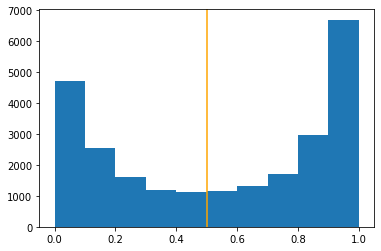

In [36]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
# orange line is 0.5 threshhold

In [0]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [38]:
"{:0.2f}".format(pct_auc) # auc is high

'92.47'

In [0]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
#making y_hat value to float format

In [0]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [43]:
ydf.head(10)

y_hat  y
0  0.385186  0
1  0.935852  1
2  0.812116  1
3  0.420909  0
4  0.991204  1
5  0.777177  1
6  0.824466  1
7  0.096654  0
8  0.904231  0
9  0.733229  1

In [44]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [45]:
' '.join(index_word[id] for id in all_x_valid[6]) 

"START originally supposed to be just a part of a huge epic the year 1905 depicting the revolution of 1905 potemkin is the story of the mutiny of the crew of the potemkin in odessa harbor the film opens with the crew protesting meat and the captain ordering the execution of the an uprising takes place during which the revolutionary leader is killed this crewman is taken to the shore to lie in state when the townspeople gather on a huge flight of steps overlooking the harbor czarist troops appear and march down the steps breaking up the crowd a naval squadron is sent to retake the potemkin but at the moment when the ships come into range their crews allow the to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was the seed of the later bolshevik revolution that would bloom in russia the film is broken into five parts men and maggots drama on the an appeal from the dead the odessa steps and meeting the squadron br br eisenstein was a revo

In [46]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)
# check when my model predicted over 0.9 but in real it was negative
#false positve

y_hat  y
8    0.904231  0
152  0.902265  0
386  0.946613  0
593  0.915137  0
680  0.963221  0
693  0.938322  0
740  0.940039  0
778  0.940001  0
781  0.961105  0
810  0.948371  0

In [47]:
' '.join(index_word[id] for id in all_x_valid[386]) 
# it contains positive comment that's why it confused

"START wow another kevin costner hero movie postman tin cup waterworld bodyguard wyatt earp robin hood even that baseball movie seems like he makes movies specifically to be the center of attention the characters are almost always the same the heroics the flaws the greatness the fall the redemption yup within the 1st 5 minutes of the movie we're all supposed to be in awe of his character and it builds up more and more from there br br and this time the story story is just a collage of different movies you don't need a spoiler you've seen this movie several times though it had different titles you'll know what will happen way before it happens this is like mixing an officer and a gentleman with but both are easily better movies watch to see how this kind of movie should be made and also to see how an good but slightly underrated actor russell plays the hero"

In [48]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)
# positive in real but predicted confidently negative 0.1 below

y_hat  y
300   0.059803  1
667   0.051335  1
1261  0.086648  1
2027  0.043422  1
2096  0.064215  1
2330  0.072255  1
2372  0.043041  1
2550  0.074275  1
2733  0.045486  1
2908  0.091684  1

In [50]:
' '.join(index_word[id] for id in all_x_valid[300]) 
# horror movie 'horror' was not considered in sequencial

"START nurse charlotte beale the lovely rosie has arrived to dr clinic for the insane prepared for a new job what she doesn't expect is to find another supposed doctor in his position after stephens is attacked by axe wielding maniacal judge oliver w cameron in a running gag anytime he confronts a situation out of his control he retreats to repeating his name that doctor is geraldine masters annabelle who isn't sure about whether beale is a proper fit for their establishment after a long discussion about the position which is quite an awkward scene as the two debate about being sent a letter by stephens getting a job at the clinic with masters often reminding her that he is no longer in charge masters agrees to let her work in the nursing position but the good doctor may not be who she seems br br the assortment of loonies includes sam bill mcgee a simple minded child man who was last victim of lobotomy jennifer warren a woman who needs an adult to comfort her as she wallows at masters